<a href="https://colab.research.google.com/github/FrontAnalyticsInc/data-winners/blob/main/Semantic_Similarity_of_Keywords_and_Titles_a_SEO_task_using_TF_Hub_Universal_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Similarity between Keywords and Titles

1.   List item
2.   List item




<table align="left">
  <td>
  <a href="https://wordlift.io">
    <img width=130px src="https://wordlift.io/wp-content/uploads/2018/07/logo-assets-510x287.png" />
    </a>
    </td>
  <td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View the original from The TF-Hub team</a>
</td></table>


This notebook has been created to see how the Universal Sentence Encoder can be used for assesing the **semantic similarity** between *a search query* (triggered on Goggle) and *the title* of the content being searched for that query.

The sentence embeddings can be trivially used to compute the meaning similarity and to understand if a given title can be further optimised to match its main search query. Read the blog post here: "[Title Tag SEO using TensorFlow](https://wordlift.io/blog/en/title-tag-seo-using-ai/)".

# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [ ]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from google.colab import files


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

Here below a simple test. Replace the strings for each message (`word`, `sentence` and `paragraph`) and get the embeddings. 

In [ ]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "SEO"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

RuntimeError: ignored

# Evaluate Similarity between Keywords and Titles 
### Read CSV data with *Title* and *Keywords*

The goal here is to get the embeddings for each keyword and the embeddings for its corresponding title. 

We do this by reading a csv file that contains keywords, titles and position in the Google SERP. We extract the embeddings using TF-Hun Universal Encoder and we compute the semantic similarity by calculating the inner product between the two vectors. 

The csv file shall contain a column called *Title* and a column called *Keyword*. Remember that all uploaded files are deleted when the runtime is recycled (so you will need to re-upload them again).


In [ ]:
# Open the CSV file - you can use the upload on the left and change the file name below 
df = pd.read_csv("luxuryretreats.com_2019-05-20_GSC.csv")
print("Number of rows in csv", len(df)) 
df.head(15)


Number of rows in csv 7577


,url,keys,clicks,impressions,ctr,position,device,title
0,https://www.luxuryretreats.com/,luxury retreats,89,409,0.217604,1.019560,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
1,https://www.luxuryretreats.com/,luxuryretreats,8,91,0.087912,1.000000,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
2,https://www.luxuryretreats.com/,luxury rentals,6,79,0.075949,3.506329,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
3,https://www.luxuryretreats.com/,luxury vacation rentals,6,75,0.080000,11.373333,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
4,https://www.luxuryretreats.com/,luxury villas,6,114,0.052632,4.052632,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
5,https://www.luxuryretreats.com/,luxury retreat,5,19,0.263158,1.157895,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
6,https://www.luxuryretreats.com/destinations,luxury retreats,4,382,0.010471,1.026178,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
7,https://www.luxuryretreats.com/,luxury retreats.com,4,11,0.363636,1.000000,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
8,https://www.luxuryretreats.com/,luxury airbnb,3,34,0.088235,4.558824,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...
9,https://www.luxuryretreats.com/,luxury home rentals,3,20,0.150000,2.200000,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...


### Produce the embeddings and compute the similarity 


In [ ]:
embed = hub.Module(module_url)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

queries = []
results = []

# Filter unique queries by chosing only top ranking positions - this in the case of CSV file with multiple queries for each URL
# df = df.sort_values('wordlift.io en-US Top Rank', ascending=True).drop_duplicates(['wordlift.io en-US Top Ranking URL'])


# Build the list of Titles and Keywords
for index, row in df.iterrows():
 
  #Remove everything after " | " from the Title 
  #results.append(df.iloc[index]['title'].split('|')[0])
  
  results.append(df.iloc[index]['title'])
  queries.append(df.iloc[index]['keys'])

# Create the TF Session and get the embeddings for both Titles and Keywords  
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  results_embeddings = session.run(embed(results))
  queries_embeddings = session.run(embed(queries))

  # Compute the similarity   
  for i, results_embedding in enumerate(np.array(results_embeddings).tolist()):
    print("Title: {}".format(results[i]))
    print("Keyword: {}".format(queries[i]))
    corr = np.inner(results_embeddings[i], queries_embeddings[i])
    print(corr)
    df.at[i, 'corr'] = corr
    df.at[i, 'title'] = format(results[i])
  

Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury retreats
0.64019465
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxuryretreats
0.07609062
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury rentals
0.73549783
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury vacation rentals
0.8319179
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury villas
0.73327655
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury retreat
0.5588426
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury retreats
0.64019465
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury retreats.com
0.40610877
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury airbnb
0.79242504
Title: Luxury Villa Rentals & Vacation Rentals | Luxury Retreats
Keyword: luxury home re

In [ ]:
# save data to CSV

df.to_csv('df.csv')
files.download('df.csv')


### Plot the correlation between Similarity (Corr) and Position in the SERP


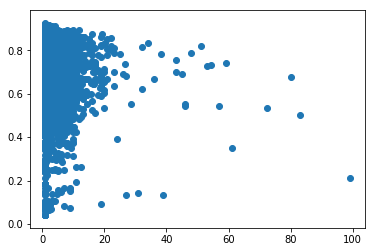

In [ ]:
plt.scatter(df['position'], df['corr'])

### Get the list of pages in after the top 4 positions with the greatest semantic distance and the highest number of clicks



In [ ]:
# Focus only on combinations after the top 4 positions and
# sort the results starting with the most distant (Corr is the semantic distance) with the highest 
# number of clicks 

df[df['position'] > 4].sort_values(by=['corr','clicks'], ascending=[True,False])\
    .drop_duplicates(['url']).head(30)



,url,keys,clicks,impressions,ctr,position,device,title,corr
6664,https://www.luxuryretreats.com/vacation-rental...,15,0,1,0.000000,9.000000,tablet,15 Ottawa | Luxury Retreats,0.073972
534,https://www.luxuryretreats.com/,luxuryvilla,2,2,1.000000,7.000000,mobile,Luxury Villa Rentals & Vacation Rentals | Luxu...,0.082070
6392,https://www.luxuryretreats.com/vacation-rental...,dimora ghirlandaio,1,1,1.000000,19.000000,desktop,Luxury Villa Rentals & Vacation Rentals | Luxu...,0.091342
807,https://www.luxuryretreats.com/vacation-rental...,bleu rivage,1,1,1.000000,39.000000,desktop,Luxury Villa Rentals & Vacation Rentals | Luxu...,0.133312
5830,https://www.luxuryretreats.com/s/Cor-Na-Ron-Ea...,ron east,1,1,1.000000,27.000000,tablet,Cor Na Ron East Villas & Vacation Rentals | Lu...,0.134397
4346,https://www.luxuryretreats.com/vacation-rental...,casataupuntamita,2,14,0.142857,4.642857,mobile,Casa Tau | Luxury Retreats,0.139625
2929,https://www.luxuryretreats.com/vacation-rental...,batell,1,1,1.000000,31.000000,desktop,Villa Batell | Luxury Retreats,0.142657
1031,https://www.luxuryretreats.com/vacation-rental...,estoublon,1,2,0.500000,6.000000,tablet,Chateau d'Estoublon | Luxury Retreats,0.148508
3200,https://www.luxuryretreats.com/vacation-rental...,aggia,0,1,0.000000,9.000000,tablet,Villa Aggia | Luxury Retreats,0.152390
3203,https://www.luxuryretreats.com/vacation-rental...,alabali,0,1,0.000000,5.000000,tablet,Villa Alabali | Luxury Retreats,0.154993


# Semantic Textual Similarity Visualized

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of keyword and title can be trivially computed as the inner product of the encodings.

In [ ]:
# Get 10 combinations of keywords and titles and build a list

messages = pd.concat([df["keys"],df["title"]]).sort_index().values.tolist()
del messages[20:len(messages)]

print(messages)


['luxury retreats', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxuryretreats', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury rentals', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury vacation rentals', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury villas', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury retreat', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury retreats', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury retreats.com', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury airbnb', 'Luxury Villa Rentals & Vacation Rentals | Luxury Retreats', 'luxury home rentals']


In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

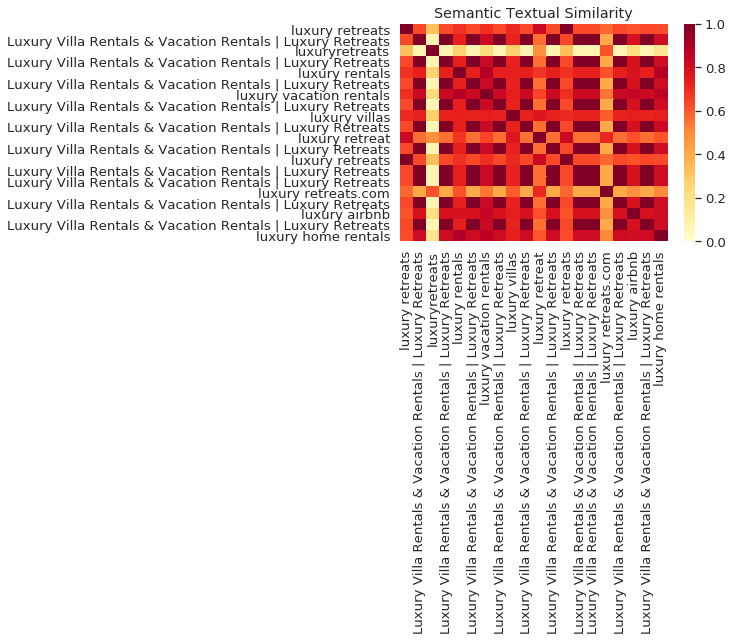

In [ ]:


similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a matrix (size depending from the lenght of the list messages configured above)where each entry `[keyword, title]` is colored based on the inner product of the encodings for sentence `keyword` and `title`.

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================